In [1]:
latest_gameweek = 34

In [2]:
# PARAMETERS

# which game in the future are you trying to predict? shift_param=1 means the next game (2 means the one after that etc.)
shift_param = 1

In [3]:
# IMPORTS

import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import os

import catboost 
#import shap
import optuna
import mlflow

from sklearn import linear_model
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from src.utils import calculate_performance_metrics

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Fetch data

In [4]:
filepath = Path('../data/fpl_df.csv')
fpl_df = pd.read_csv(filepath, index_col=0, low_memory=False)
display(fpl_df.head())
display(fpl_df.shape)

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,...,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime
0,0,0,3,0,NaN,0.0,493,188,4.0,0,2,1,David,0,0,0.0,497,188,0.0,490,188,1,55,0,0,NaN,0,1.0,0,0,Luiz Moreira Marinho,0.9,0.0,479,186,1,David Luiz,0,Arsenal,2,20-21,0.0,0.0,1.9,1.0,1.4,1.9,1.8,1.8,1.8,1.8,0.2,0.2,0.2,0.2,1.9,1.4,1.1

(28619, 209)

# Fetch model

In [5]:
# choose models
model_paths = [
    Path('../models/catboost_20230809-201635.cbm'),
    Path('../models/catboost_20240102-210118.cbm')
]

In [6]:
# load prediction models

models = []
model_creation_dates = []
for path in model_paths:
    model = catboost.CatBoostRegressor()
    model_creation_year = int(str(path)[19:23])
    model_creation_month = int(str(path)[23:25])
    model_creation_day = int(str(path)[25:27])
    model_creation_date = dt.date(model_creation_year, model_creation_month, model_creation_day)
    model_creation_dates.append(model_creation_date)
    model.load_model(path)    
    models.append(model.copy())
    print(f'Model created on {model_creation_date}')

Model created on 2023-08-09
Model created on 2024-01-02


# Test model predictions

Test model predictions on new data collected after the model was trained.

In [7]:
df = fpl_df.copy()

In [8]:
features_no_shift = ['element_type', 'home', 'opponent_xG_ewm_5', 'opponent_xG_ewm_10',
       'opponent_xG_ewm_20', 'opponent_xG_ewm_40', 'opponent_xGA_ewm_5',
       'opponent_xGA_ewm_10', 'opponent_xGA_ewm_20',
       'opponent_xGA_ewm_40', ]

features_shift = ['corners_and_indirect_freekicks_order', 'creativity_rank', 
       'direct_freekicks_order', 'ict_index_rank', 'influence_rank',
       'minutes', 'now_cost', 'penalties_order', 'points_per_game', 
       'selected_by_percent', 'threat_rank',
       'team_xG_ewm_5', 'team_xG_ewm_10', 'team_xG_ewm_20',
       'team_xG_ewm_40', 'team_xGA_ewm_5', 'team_xGA_ewm_10',
       'team_xGA_ewm_20', 'team_xGA_ewm_40', 
       'gameweek_assists_ewm_5', 'gameweek_bps_ewm_5',
       'gameweek_creativity_ewm_5', 'event_points_ewm_5',
       'gameweek_goals_scored_ewm_5', 'gameweek_goals_conceded_ewm_5',
       'gameweek_saves_ewm_5', 'gameweek_threat_ewm_5',
       'gameweek_xG_ewm_5', 'gameweek_xA_ewm_5', 'gameweek_xGA_ewm_5',
       'gameweek_minutes_ewm_5', 'gameweek_xPoints_ewm_5',
       'gameweek_assists_ewm_10', 'gameweek_bps_ewm_10',
       'gameweek_creativity_ewm_10', 'event_points_ewm_10',
       'gameweek_goals_scored_ewm_10', 'gameweek_goals_conceded_ewm_10',
       'gameweek_saves_ewm_10', 'gameweek_threat_ewm_10',
       'gameweek_xG_ewm_10', 'gameweek_xA_ewm_10', 'gameweek_xGA_ewm_10',
       'gameweek_minutes_ewm_10', 'gameweek_xPoints_ewm_10',
       'gameweek_assists_ewm_20', 'gameweek_bps_ewm_20',
       'gameweek_creativity_ewm_20', 'event_points_ewm_20',
       'gameweek_goals_scored_ewm_20', 'gameweek_goals_conceded_ewm_20',
       'gameweek_saves_ewm_20', 'gameweek_threat_ewm_20',
       'gameweek_xG_ewm_20', 'gameweek_xA_ewm_20', 'gameweek_xGA_ewm_20',
       'gameweek_minutes_ewm_20', 'gameweek_xPoints_ewm_20',
       'gameweek_assists_ewm_40', 'gameweek_bps_ewm_40',
       'gameweek_creativity_ewm_40', 'event_points_ewm_40',
       'gameweek_goals_scored_ewm_40', 'gameweek_goals_conceded_ewm_40',
       'gameweek_saves_ewm_40', 'gameweek_threat_ewm_40',
       'gameweek_xG_ewm_40', 'gameweek_xA_ewm_40', 'gameweek_xGA_ewm_40',
       'gameweek_minutes_ewm_40', 'gameweek_xPoints_ewm_40',
       'gameweek_assists_expanding', 'gameweek_bps_expanding',
       'gameweek_creativity_expanding', 'event_points_expanding',
       'gameweek_goals_scored_expanding',
       'gameweek_goals_conceded_expanding', 'gameweek_saves_expanding',
       'gameweek_threat_expanding', 'gameweek_xG_expanding',
       'gameweek_xA_expanding', 'gameweek_xGA_expanding',
       'gameweek_minutes_expanding', 'gameweek_xPoints_expanding',
       'gameweek_assists_expanding_per90', 'gameweek_bps_expanding_per90',
       'gameweek_creativity_expanding_per90',
       'event_points_expanding_per90',
       'gameweek_goals_scored_expanding_per90',
       'gameweek_goals_conceded_expanding_per90',
       'gameweek_saves_expanding_per90',
       'gameweek_threat_expanding_per90', 'gameweek_xG_expanding_per90',
       'gameweek_xA_expanding_per90', 'gameweek_xGA_expanding_per90',
       'gameweek_xPoints_expanding_per90', 'xG_overperformance'
    ]

features = features_no_shift + features_shift

target = ['event_points']

In [9]:
# shift give features
df[features_shift] = df.groupby('web_name')[features_shift].shift(shift_param)
display(df.head())
display(df.tail())
display(df.shape)

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,...,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime
0,0,0,3,0,NaN,0.0,NaN,188,NaN,0,2,1,David,0,0,0.0,NaN,188,0.0,NaN,188,NaN,NaN,0,0,NaN,0,NaN,0,0,Luiz Moreira Marinho,NaN,0.0,NaN,186,1,David Luiz,0,Arsenal,2,20-21,0.0,0.0,1.9,1.0,1.4,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,1.4,

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,...,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime
28614,4,3,402,4,NaN,90.9,299.0,95,NaN,0,2,0,Toti António,37,0,66.5,214.0,64,437.6,131.0,44,2232.0,44.0,0,0,NaN,0,2.3,0,0,Gomes,0.3,133.0,217.0,54,68,Toti,6,Wolves,34,23-24,0.00,0.00,1.21,90.0,0.1,1.2,1.279593,1.308636,1.260454,1

(28619, 209)

In [10]:
data_for_evaluation_all = []
y_true_all = []
y_predicted_all = []

for i in range(len(models)):
    model = models[i]
    model_creation_date = model_creation_dates[i]

    data_retrieval_times = pd.to_datetime(df.data_retrieved_datetime).dt.date
    data_for_evaluation = df.loc[(data_retrieval_times > model_creation_date)].copy()
    data_for_evaluation = data_for_evaluation.reset_index(drop=True)

    X = data_for_evaluation[features].copy()
    y_true = data_for_evaluation[target]
    y_predicted = model.predict(X)
    display(f'Number of data points for model {i}: {X.shape[0]}')

    data_for_evaluation_all.append(data_for_evaluation.copy())
    y_true_all.append(y_true.copy())
    y_predicted_all.append(y_predicted)

'Number of data points for model 0: 9780'

'Number of data points for model 1: 4160'

### All new data

In [11]:
for i in range(len(models)):
    print(F'MODEL {i}')
    mae, rmse, r2 = calculate_performance_metrics(y_true_all[i].values.flatten(), y_predicted_all[i])
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'r^2: {r2}')

MODEL 0


MAE: 2.0482605483295853
RMSE: 2.852712394848385
r^2: 0.09090450296276331
MODEL 1


MAE: 2.078074148177055
RMSE: 2.918710823392996
r^2: 0.09240570968436679


### Gameweek-by-gameweek results

In [12]:
metrics_all = []
for i in range(len(models)):

    gameweeks = data_for_evaluation_all[i].gameweek.unique()
    metrics_list = []
    for my_gameweek in gameweeks:
        gameweek_ix = data_for_evaluation_all[i][data_for_evaluation_all[i].gameweek==my_gameweek].index
        mae, rmse, r2 = calculate_performance_metrics(y_true_all[i].loc[gameweek_ix].values.flatten(), 
                                                      y_predicted_all[i][gameweek_ix], 
                                                      plot=False)
        metrics_list.append([mae, rmse, r2])
        metrics_dict = {'mae_gameweek':mae, 'rmse_gameweek':rmse, 'r2_gameweek':r2}
        #mlflow.log_metrics(metrics_dict, step=my_gameweek) 

    metrics = pd.DataFrame(metrics_list, columns=['mae', 'rmse', 'r2'], index=gameweeks)
    metrics_all.append(metrics.copy())
    #display(metrics)

fig = go.Figure()
for i in range(len(models)):
    fig.add_trace(
        go.Scatter(
            x=metrics_all[i].index, 
            y=metrics_all[i].r2, 
            mode='lines+markers',
            name=f'Model {i}',
        )
    )

fig.update_layout(
    xaxis_title='gameweek',
    yaxis_title='r^2',
)

fig.show()
    

# Re-fit existing model with new data added

### Data processing

In [13]:
df = fpl_df.copy()

In [14]:
features_no_shift = ['element_type', 'home', 'opponent_xG_ewm_5', 'opponent_xG_ewm_10',
       'opponent_xG_ewm_20', 'opponent_xG_ewm_40', 'opponent_xGA_ewm_5',
       'opponent_xGA_ewm_10', 'opponent_xGA_ewm_20',
       'opponent_xGA_ewm_40', ]

features_shift = ['corners_and_indirect_freekicks_order', 'creativity_rank', 
       'direct_freekicks_order', 'ict_index_rank', 'influence_rank',
       'minutes', 'now_cost', 'penalties_order', 'points_per_game', 
       'selected_by_percent', 'threat_rank',
       'team_xG_ewm_5', 'team_xG_ewm_10', 'team_xG_ewm_20',
       'team_xG_ewm_40', 'team_xGA_ewm_5', 'team_xGA_ewm_10',
       'team_xGA_ewm_20', 'team_xGA_ewm_40', 
       'gameweek_assists_ewm_5', 'gameweek_bps_ewm_5',
       'gameweek_creativity_ewm_5', 'event_points_ewm_5',
       'gameweek_goals_scored_ewm_5', 'gameweek_goals_conceded_ewm_5',
       'gameweek_saves_ewm_5', 'gameweek_threat_ewm_5',
       'gameweek_xG_ewm_5', 'gameweek_xA_ewm_5', 'gameweek_xGA_ewm_5',
       'gameweek_minutes_ewm_5', 'gameweek_xPoints_ewm_5',
       'gameweek_assists_ewm_10', 'gameweek_bps_ewm_10',
       'gameweek_creativity_ewm_10', 'event_points_ewm_10',
       'gameweek_goals_scored_ewm_10', 'gameweek_goals_conceded_ewm_10',
       'gameweek_saves_ewm_10', 'gameweek_threat_ewm_10',
       'gameweek_xG_ewm_10', 'gameweek_xA_ewm_10', 'gameweek_xGA_ewm_10',
       'gameweek_minutes_ewm_10', 'gameweek_xPoints_ewm_10',
       'gameweek_assists_ewm_20', 'gameweek_bps_ewm_20',
       'gameweek_creativity_ewm_20', 'event_points_ewm_20',
       'gameweek_goals_scored_ewm_20', 'gameweek_goals_conceded_ewm_20',
       'gameweek_saves_ewm_20', 'gameweek_threat_ewm_20',
       'gameweek_xG_ewm_20', 'gameweek_xA_ewm_20', 'gameweek_xGA_ewm_20',
       'gameweek_minutes_ewm_20', 'gameweek_xPoints_ewm_20',
       'gameweek_assists_ewm_40', 'gameweek_bps_ewm_40',
       'gameweek_creativity_ewm_40', 'event_points_ewm_40',
       'gameweek_goals_scored_ewm_40', 'gameweek_goals_conceded_ewm_40',
       'gameweek_saves_ewm_40', 'gameweek_threat_ewm_40',
       'gameweek_xG_ewm_40', 'gameweek_xA_ewm_40', 'gameweek_xGA_ewm_40',
       'gameweek_minutes_ewm_40', 'gameweek_xPoints_ewm_40',
       'gameweek_assists_expanding', 'gameweek_bps_expanding',
       'gameweek_creativity_expanding', 'event_points_expanding',
       'gameweek_goals_scored_expanding',
       'gameweek_goals_conceded_expanding', 'gameweek_saves_expanding',
       'gameweek_threat_expanding', 'gameweek_xG_expanding',
       'gameweek_xA_expanding', 'gameweek_xGA_expanding',
       'gameweek_minutes_expanding', 'gameweek_xPoints_expanding',
       'gameweek_assists_expanding_per90', 'gameweek_bps_expanding_per90',
       'gameweek_creativity_expanding_per90',
       'event_points_expanding_per90',
       'gameweek_goals_scored_expanding_per90',
       'gameweek_goals_conceded_expanding_per90',
       'gameweek_saves_expanding_per90',
       'gameweek_threat_expanding_per90', 'gameweek_xG_expanding_per90',
       'gameweek_xA_expanding_per90', 'gameweek_xGA_expanding_per90',
       'gameweek_xPoints_expanding_per90', 'xG_overperformance'
    ]

target = ['event_points']

In [15]:
# shift given features
df[features_shift] = df.groupby('web_name')[features_shift].shift(shift_param)
display(df.head())
display(df.tail())
display(df.shape)

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,...,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime
0,0,0,3,0,NaN,0.0,NaN,188,NaN,0,2,1,David,0,0,0.0,NaN,188,0.0,NaN,188,NaN,NaN,0,0,NaN,0,NaN,0,0,Luiz Moreira Marinho,NaN,0.0,NaN,186,1,David Luiz,0,Arsenal,2,20-21,0.0,0.0,1.9,1.0,1.4,1.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,1.4,

,assists,bonus,bps,clean_sheets,corners_and_indirect_freekicks_order,creativity,creativity_rank,creativity_rank_type,direct_freekicks_order,dreamteam_count,element_type,event_points,first_name,goals_conceded,goals_scored,ict_index,ict_index_rank,ict_index_rank_type,influence,influence_rank,influence_rank_type,minutes,now_cost,own_goals,penalties_missed,penalties_order,penalties_saved,points_per_game,red_cards,saves,second_name,selected_by_percent,threat,threat_rank,threat_rank_type,total_points,web_name,yellow_cards,team_name,gameweek,season,gameweek_xG,gameweek_xA,gameweek_xGA,gameweek_minutes,team_xG,team_xGA,team_xG_ewm_5,team_xG_ewm_10,team_xG_ewm_20,team_xG_ewm_40,team_xGA_ewm_5,team_xGA_ewm_10,team_xGA_ewm_20,team_xGA_ewm_40,opponent_xG,opponent_xGA,opponent_xG_ewm_5,opponent_xG_ewm_10,opponent_xG_ewm_20,opponent_xG_ewm_40,opponent_xGA_ewm_5,opponent_xGA_ewm_10,opponent_xGA_ewm_20,opponent_xGA_ewm_40,home,gameweek_assists,gameweek_bps,gameweek_creativity,gameweek_goals_scored,gameweek_goals_conceded,gameweek_own_goals,gameweek_penalties_saved,gameweek_red_cards,gameweek_saves,gameweek_threat,gameweek_yellow_cards,gameweek_xPoints,gameweek_assists_ewm_5,gameweek_bps_ewm_5,gameweek_creativity_ewm_5,event_points_ewm_5,gameweek_goals_scored_ewm_5,gameweek_goals_conceded_ewm_5,gameweek_saves_ewm_5,gameweek_threat_ewm_5,gameweek_xG_ewm_5,gameweek_xA_ewm_5,gameweek_xGA_ewm_5,gameweek_minutes_ewm_5,gameweek_xPoints_ewm_5,gameweek_assists_ewm_10,gameweek_bps_ewm_10,gameweek_creativity_ewm_10,event_points_ewm_10,gameweek_goals_scored_ewm_10,gameweek_goals_conceded_ewm_10,gameweek_saves_ewm_10,gameweek_threat_ewm_10,gameweek_xG_ewm_10,...,gameweek_goals_conceded_ewm_20,gameweek_saves_ewm_20,gameweek_threat_ewm_20,gameweek_xG_ewm_20,gameweek_xA_ewm_20,gameweek_xGA_ewm_20,gameweek_minutes_ewm_20,gameweek_xPoints_ewm_20,gameweek_assists_ewm_40,gameweek_bps_ewm_40,gameweek_creativity_ewm_40,event_points_ewm_40,gameweek_goals_scored_ewm_40,gameweek_goals_conceded_ewm_40,gameweek_saves_ewm_40,gameweek_threat_ewm_40,gameweek_xG_ewm_40,gameweek_xA_ewm_40,gameweek_xGA_ewm_40,gameweek_minutes_ewm_40,gameweek_xPoints_ewm_40,gameweek_assists_expanding,gameweek_bps_expanding,gameweek_creativity_expanding,event_points_expanding,gameweek_goals_scored_expanding,gameweek_goals_conceded_expanding,gameweek_saves_expanding,gameweek_threat_expanding,gameweek_xG_expanding,gameweek_xA_expanding,gameweek_xGA_expanding,gameweek_minutes_expanding,gameweek_xPoints_expanding,gameweek_assists_expanding_per90,gameweek_bps_expanding_per90,gameweek_creativity_expanding_per90,event_points_expanding_per90,gameweek_goals_scored_expanding_per90,gameweek_goals_conceded_expanding_per90,gameweek_saves_expanding_per90,gameweek_threat_expanding_per90,gameweek_xG_expanding_per90,gameweek_xA_expanding_per90,gameweek_xGA_expanding_per90,gameweek_minutes_expanding_per90,gameweek_xPoints_expanding_per90,xG_overperformance,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,ep_next,ep_this,form,id,in_dreamteam,news,news_added,photo,special,squad_number,status,team,team_code,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,corners_and_indirect_freekicks_text,direct_freekicks_text,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90,name,data_retrieved_datetime
28614,4,3,402,4,NaN,90.9,299.0,95,NaN,0,2,0,Toti António,37,0,66.5,214.0,64,437.6,131.0,44,2232.0,44.0,0,0,NaN,0,2.3,0,0,Gomes,0.3,133.0,217.0,54,68,Toti,6,Wolves,34,23-24,0.00,0.00,1.21,90.0,0.1,1.2,1.279593,1.308636,1.260454,1

(28619, 209)

<Axes: ylabel='Frequency'>

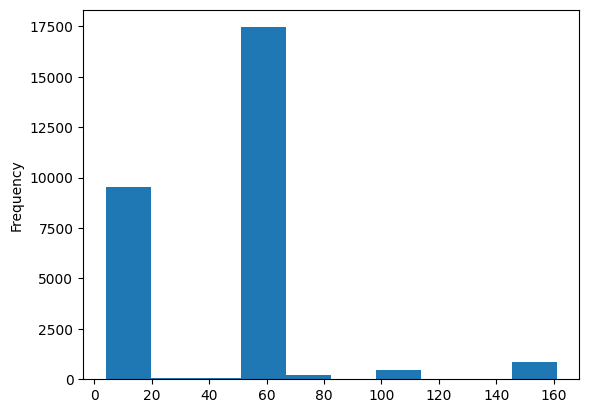

In [16]:
df.isnull().sum(axis=1).plot(kind='hist')

In [17]:
# drop rows where too much data missing
df = df[df.isnull().sum(axis=1) <= 100].reset_index(drop=True)
display(df.shape)

(27299, 209)

In [18]:
X = df[features_no_shift + features_shift].copy()
y = df[target].copy()

display(X.shape)
display(y.shape)

(27299, 107)

(27299, 1)

In [19]:
# fit and log model
model = models[0]
with mlflow.start_run() as run:
    model.fit(X,y)
    mlflow.catboost.log_model(model, f'gameweek_{latest_gameweek}')